In [1]:
import numpy as np
import rospy
import sys

import time
from tqdm import tqdm
import random
from mobile_control import deep_mobile_control
from collections import deque

from keras import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam,SGD
from keras.models import load_model

Using TensorFlow backend.
/home/luu/Desktop/Environments/deep_ros/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luu/Desktop/Environments/deep_ros/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luu/Desktop/Environments/deep_ros/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:

#Hyperparameters
gamma = 0.9
lr =0.7
lr_decay=0.999
num_iterations =10000
epsilon =1
epsilon_decay =0.999999
delay_time=0.1
vels=[[1,0],[0.5,1],[0.5,-1],[0,1],[0,-1],[-0.8,0]]
legal_actions=len(vels)
batch_size=128
memory_size=2000

In [3]:
memory = deque(maxlen=memory_size)

In [5]:
def take_action(a):
    Robot.vel.linear.x = a[0]
    Robot.vel.angular.z=a[1]
    Robot.cmd_vel.publish(Robot.vel)
def choose_action(epsilon,s):
        #epsilon greedy. to choose random actions initially when Q is all zeros
    if np.random.random()<epsilon:
        action_index=np.random.randint(0,legal_actions)
        a =vels[action_index]
        epsilon = epsilon*epsilon_decay
        #print('Took random action')
    else:
        Q = model.predict(np.array([s]))
        a =vels[np.argmax(Q)]
    return a
def get_state():
    s_temp=Robot.data_laser
    ang_sp=Robot.odom_data.angular.z
    lin_sp=Robot.odom_data.linear.x
    s_temp=np.append(s_temp,[ang_sp,lin_sp])
    return s_temp
def test_model():
    while (1):
        s=get_state()
        a=model.predict(s)
        action_index=np.argmax(a)
        a =actions[action_index]
        take_action(a)    
def experience_replay():
    #experience replay
    for _ in range(memory_size):
        s=get_state()
        a = vels[np.random.randint(0,legal_actions)]
        Robot.vel.linear.x=a[0]
        Robot.vel.angular.z=a[1]
        Robot.cmd_vel.publish(Robot.vel)
        time.sleep(delay_time)
        s1=get_state()
        r=max(Robot.odom_data.linear.x,0)
        experience =(s,r,a,s1)
        memory.append(experience)
def check_robot():
        if(abs(Robot.imu_x)>0.1 or abs(Robot.imu_y)>0.1):
            Robot.reset()
        if(abs(Robot.odom_data.linear.x)>4 or abs(Robot.odom_data.angular.z)>4):
            Robot.reset()

In [6]:
rospy.init_node('Mobile',anonymous=True)
Robot = deep_mobile_control()
Robot.reset()

In [66]:

#model=load_model('model1.h5')

opt=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#opt=SGD(learning_rate=0.00000000001, momentum=0.9, nesterov=False)
model = Sequential()

model.add(Dense(200,activation='sigmoid',input_dim=7,kernel_initializer='random_uniform',use_bias='True'))
model.add(Dense(100,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
#model.add(Dropout(0.4))

model.add(Dense(100,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
model.add(Dense(50,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
model.add(Dense(50,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
#model.add(Dropout(0.5))
model.add(Dense(20,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
model.add(Dense(10,activation='sigmoid',kernel_initializer='random_uniform',use_bias='True'))
model.add(Dense(legal_actions,activation='linear',kernel_initializer='random_uniform',use_bias='True'))
model.compile(loss='mean_absolute_error',optimizer=opt)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 200)               1600      
_________________________________________________________________
dense_52 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_54 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_55 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_56 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_57 (Dense)             (None, 10)               

In [36]:
experience_replay()

In [50]:
legal_actions

6

In [67]:
batches=random.sample(memory,128)

states= np.array([batch[0] for batch in batches])
rewards= np.array([batch[1] for batch in batches])
actions= np.array([batch[2] for batch in batches])
new_states= np.array([batch[3] for batch in batches])

Qs =model.predict(states)
new_Qs = model.predict(new_states)
y=4
for i in range(len(rewards)):
    action_index=vels.index(list(actions[i]))
    if i==y:
        print('Old Q:',Qs[i][action_index])
    #action_index=list(vels).index(actions[i])
    #print(action_index)
    #Qs[i][action_index]= (1-lr)*(Qs[i][action_index])+ lr*(rewards[i]+gamma*max(new_Qs[i]))
    Qs[i][action_index]= rewards[i]+gamma*np.max(new_Qs[i])
    if i==y:
        print('states:',states[i])
        print('next_state:',new_states[i])
        print('index:',action_index)
        print('updated Q:',Qs[i][action_index])
        print('rewards:',rewards[i])
        print('qs:',model.predict(states)[i])
        print('pred_qs:',Qs[i])
        print('new_qs:',new_Qs[i])
        print(rewards[i]+gamma*max(new_Qs[i]))

Old Q: 0.09591551
states: [1.23534334 2.         2.         1.08946538 2.         0.62860205
 0.02939186]
next_state: [ 1.00133157e+00  2.00000000e+00  2.00000000e+00  1.09095109e+00
  2.00000000e+00 -9.40379045e-01  9.83601022e-05]
index: 3
updated Q: 0.08642232
rewards: 9.836010216013188e-05
qs: [ 0.03025956  0.01161022 -0.03760374  0.09591551  0.01208357 -0.02038085]
pred_qs: [ 0.03025956  0.01161022 -0.03760374  0.08642232  0.01208357 -0.02038085]
new_qs: [ 0.03025956  0.01161022 -0.03760374  0.09591551  0.01208357 -0.02038085]
0.08642232022760646


In [68]:
history=model.fit(states,Qs,verbose=2,batch_size=128,epochs = 4000)

Epoch 1/4000
 - 1s - loss: 0.0376
Epoch 2/4000
 - 0s - loss: 0.0381
Epoch 3/4000
 - 0s - loss: 0.0378
Epoch 4/4000
 - 0s - loss: 0.0378
Epoch 5/4000
 - 0s - loss: 0.0378
Epoch 6/4000
 - 0s - loss: 0.0378
Epoch 7/4000
 - 0s - loss: 0.0377
Epoch 8/4000
 - 0s - loss: 0.0378
Epoch 9/4000
 - 0s - loss: 0.0377
Epoch 10/4000
 - 0s - loss: 0.0377
Epoch 11/4000
 - 0s - loss: 0.0377
Epoch 12/4000
 - 0s - loss: 0.0377
Epoch 13/4000
 - 0s - loss: 0.0377
Epoch 14/4000
 - 0s - loss: 0.0377
Epoch 15/4000
 - 0s - loss: 0.0378
Epoch 16/4000
 - 0s - loss: 0.0377
Epoch 17/4000
 - 0s - loss: 0.0377
Epoch 18/4000
 - 0s - loss: 0.0377
Epoch 19/4000
 - 0s - loss: 0.0377
Epoch 20/4000
 - 0s - loss: 0.0378
Epoch 21/4000
 - 0s - loss: 0.0377
Epoch 22/4000
 - 0s - loss: 0.0377
Epoch 23/4000
 - 0s - loss: 0.0377
Epoch 24/4000
 - 0s - loss: 0.0377
Epoch 25/4000
 - 0s - loss: 0.0377
Epoch 26/4000
 - 0s - loss: 0.0377
Epoch 27/4000
 - 0s - loss: 0.0377
Epoch 28/4000
 - 0s - loss: 0.0377
Epoch 29/4000
 - 0s - loss: 0

Epoch 232/4000
 - 0s - loss: 0.0377
Epoch 233/4000
 - 0s - loss: 0.0377
Epoch 234/4000
 - 0s - loss: 0.0377
Epoch 235/4000
 - 0s - loss: 0.0377
Epoch 236/4000
 - 0s - loss: 0.0377
Epoch 237/4000
 - 0s - loss: 0.0377
Epoch 238/4000
 - 0s - loss: 0.0377
Epoch 239/4000
 - 0s - loss: 0.0377
Epoch 240/4000
 - 0s - loss: 0.0377
Epoch 241/4000
 - 0s - loss: 0.0377
Epoch 242/4000
 - 0s - loss: 0.0377
Epoch 243/4000
 - 0s - loss: 0.0377
Epoch 244/4000
 - 0s - loss: 0.0377
Epoch 245/4000
 - 0s - loss: 0.0377
Epoch 246/4000
 - 0s - loss: 0.0377
Epoch 247/4000
 - 0s - loss: 0.0377
Epoch 248/4000
 - 0s - loss: 0.0377
Epoch 249/4000
 - 0s - loss: 0.0377
Epoch 250/4000
 - 0s - loss: 0.0377
Epoch 251/4000
 - 0s - loss: 0.0377
Epoch 252/4000
 - 0s - loss: 0.0377
Epoch 253/4000
 - 0s - loss: 0.0377
Epoch 254/4000
 - 0s - loss: 0.0377
Epoch 255/4000
 - 0s - loss: 0.0377
Epoch 256/4000
 - 0s - loss: 0.0377
Epoch 257/4000
 - 0s - loss: 0.0377
Epoch 258/4000
 - 0s - loss: 0.0377
Epoch 259/4000
 - 0s - loss:

Epoch 460/4000
 - 0s - loss: 0.0377
Epoch 461/4000
 - 0s - loss: 0.0377
Epoch 462/4000
 - 0s - loss: 0.0377
Epoch 463/4000
 - 0s - loss: 0.0377
Epoch 464/4000
 - 0s - loss: 0.0377
Epoch 465/4000
 - 0s - loss: 0.0377
Epoch 466/4000
 - 0s - loss: 0.0377
Epoch 467/4000
 - 0s - loss: 0.0377
Epoch 468/4000
 - 0s - loss: 0.0377
Epoch 469/4000
 - 0s - loss: 0.0377
Epoch 470/4000
 - 0s - loss: 0.0377
Epoch 471/4000
 - 0s - loss: 0.0377
Epoch 472/4000
 - 0s - loss: 0.0377
Epoch 473/4000
 - 0s - loss: 0.0377
Epoch 474/4000
 - 0s - loss: 0.0377
Epoch 475/4000
 - 0s - loss: 0.0377
Epoch 476/4000
 - 0s - loss: 0.0377
Epoch 477/4000
 - 0s - loss: 0.0377
Epoch 478/4000
 - 0s - loss: 0.0377
Epoch 479/4000
 - 0s - loss: 0.0377
Epoch 480/4000
 - 0s - loss: 0.0377
Epoch 481/4000
 - 0s - loss: 0.0377
Epoch 482/4000
 - 0s - loss: 0.0377
Epoch 483/4000
 - 0s - loss: 0.0377
Epoch 484/4000
 - 0s - loss: 0.0377
Epoch 485/4000
 - 0s - loss: 0.0377
Epoch 486/4000
 - 0s - loss: 0.0377
Epoch 487/4000
 - 0s - loss:

Epoch 688/4000
 - 0s - loss: 0.0377
Epoch 689/4000
 - 0s - loss: 0.0377
Epoch 690/4000
 - 0s - loss: 0.0377
Epoch 691/4000
 - 0s - loss: 0.0377
Epoch 692/4000
 - 0s - loss: 0.0377
Epoch 693/4000
 - 0s - loss: 0.0377
Epoch 694/4000
 - 0s - loss: 0.0377
Epoch 695/4000
 - 0s - loss: 0.0377
Epoch 696/4000
 - 0s - loss: 0.0377
Epoch 697/4000
 - 0s - loss: 0.0377
Epoch 698/4000
 - 0s - loss: 0.0377
Epoch 699/4000
 - 0s - loss: 0.0377
Epoch 700/4000
 - 0s - loss: 0.0377
Epoch 701/4000
 - 0s - loss: 0.0377
Epoch 702/4000
 - 0s - loss: 0.0377
Epoch 703/4000
 - 0s - loss: 0.0377
Epoch 704/4000
 - 0s - loss: 0.0377
Epoch 705/4000
 - 0s - loss: 0.0377
Epoch 706/4000
 - 0s - loss: 0.0377
Epoch 707/4000
 - 0s - loss: 0.0377
Epoch 708/4000
 - 0s - loss: 0.0377
Epoch 709/4000
 - 0s - loss: 0.0377
Epoch 710/4000
 - 0s - loss: 0.0377
Epoch 711/4000
 - 0s - loss: 0.0377
Epoch 712/4000
 - 0s - loss: 0.0377
Epoch 713/4000
 - 0s - loss: 0.0377
Epoch 714/4000
 - 0s - loss: 0.0377
Epoch 715/4000
 - 0s - loss:

Epoch 916/4000
 - 0s - loss: 0.0377
Epoch 917/4000
 - 0s - loss: 0.0377
Epoch 918/4000
 - 0s - loss: 0.0377
Epoch 919/4000
 - 0s - loss: 0.0377
Epoch 920/4000
 - 0s - loss: 0.0377
Epoch 921/4000
 - 0s - loss: 0.0377
Epoch 922/4000
 - 0s - loss: 0.0377
Epoch 923/4000
 - 0s - loss: 0.0377
Epoch 924/4000
 - 0s - loss: 0.0377
Epoch 925/4000
 - 0s - loss: 0.0377
Epoch 926/4000
 - 0s - loss: 0.0377
Epoch 927/4000
 - 0s - loss: 0.0377
Epoch 928/4000
 - 0s - loss: 0.0377
Epoch 929/4000
 - 0s - loss: 0.0377
Epoch 930/4000
 - 0s - loss: 0.0377
Epoch 931/4000
 - 0s - loss: 0.0377
Epoch 932/4000
 - 0s - loss: 0.0377
Epoch 933/4000
 - 0s - loss: 0.0377
Epoch 934/4000
 - 0s - loss: 0.0377
Epoch 935/4000
 - 0s - loss: 0.0377
Epoch 936/4000
 - 0s - loss: 0.0377
Epoch 937/4000
 - 0s - loss: 0.0377
Epoch 938/4000
 - 0s - loss: 0.0377
Epoch 939/4000
 - 0s - loss: 0.0377
Epoch 940/4000
 - 0s - loss: 0.0377
Epoch 941/4000
 - 0s - loss: 0.0377
Epoch 942/4000
 - 0s - loss: 0.0377
Epoch 943/4000
 - 0s - loss:

Epoch 1140/4000
 - 0s - loss: 0.0377
Epoch 1141/4000
 - 0s - loss: 0.0377
Epoch 1142/4000
 - 0s - loss: 0.0377
Epoch 1143/4000
 - 0s - loss: 0.0377
Epoch 1144/4000
 - 0s - loss: 0.0377
Epoch 1145/4000
 - 0s - loss: 0.0377
Epoch 1146/4000
 - 0s - loss: 0.0377
Epoch 1147/4000
 - 0s - loss: 0.0377
Epoch 1148/4000
 - 0s - loss: 0.0377
Epoch 1149/4000
 - 0s - loss: 0.0377
Epoch 1150/4000
 - 0s - loss: 0.0377
Epoch 1151/4000
 - 0s - loss: 0.0377
Epoch 1152/4000
 - 0s - loss: 0.0377
Epoch 1153/4000
 - 0s - loss: 0.0377
Epoch 1154/4000
 - 0s - loss: 0.0377
Epoch 1155/4000
 - 0s - loss: 0.0377
Epoch 1156/4000
 - 0s - loss: 0.0377
Epoch 1157/4000
 - 0s - loss: 0.0377
Epoch 1158/4000
 - 0s - loss: 0.0377
Epoch 1159/4000
 - 0s - loss: 0.0377
Epoch 1160/4000
 - 0s - loss: 0.0377
Epoch 1161/4000
 - 0s - loss: 0.0377
Epoch 1162/4000
 - 0s - loss: 0.0377
Epoch 1163/4000
 - 0s - loss: 0.0377
Epoch 1164/4000
 - 0s - loss: 0.0377
Epoch 1165/4000
 - 0s - loss: 0.0377
Epoch 1166/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 1362/4000
 - 0s - loss: 0.0377
Epoch 1363/4000
 - 0s - loss: 0.0377
Epoch 1364/4000
 - 0s - loss: 0.0377
Epoch 1365/4000
 - 0s - loss: 0.0377
Epoch 1366/4000
 - 0s - loss: 0.0377
Epoch 1367/4000
 - 0s - loss: 0.0377
Epoch 1368/4000
 - 0s - loss: 0.0377
Epoch 1369/4000
 - 0s - loss: 0.0377
Epoch 1370/4000
 - 0s - loss: 0.0377
Epoch 1371/4000
 - 0s - loss: 0.0377
Epoch 1372/4000
 - 0s - loss: 0.0377
Epoch 1373/4000
 - 0s - loss: 0.0377
Epoch 1374/4000
 - 0s - loss: 0.0377
Epoch 1375/4000
 - 0s - loss: 0.0377
Epoch 1376/4000
 - 0s - loss: 0.0377
Epoch 1377/4000
 - 0s - loss: 0.0377
Epoch 1378/4000
 - 0s - loss: 0.0377
Epoch 1379/4000
 - 0s - loss: 0.0377
Epoch 1380/4000
 - 0s - loss: 0.0377
Epoch 1381/4000
 - 0s - loss: 0.0377
Epoch 1382/4000
 - 0s - loss: 0.0377
Epoch 1383/4000
 - 0s - loss: 0.0377
Epoch 1384/4000
 - 0s - loss: 0.0377
Epoch 1385/4000
 - 0s - loss: 0.0377
Epoch 1386/4000
 - 0s - loss: 0.0377
Epoch 1387/4000
 - 0s - loss: 0.0377
Epoch 1388/4000
 

Epoch 1583/4000
 - 0s - loss: 0.0377
Epoch 1584/4000
 - 0s - loss: 0.0377
Epoch 1585/4000
 - 0s - loss: 0.0377
Epoch 1586/4000
 - 0s - loss: 0.0377
Epoch 1587/4000
 - 0s - loss: 0.0377
Epoch 1588/4000
 - 0s - loss: 0.0377
Epoch 1589/4000
 - 0s - loss: 0.0377
Epoch 1590/4000
 - 0s - loss: 0.0377
Epoch 1591/4000
 - 0s - loss: 0.0377
Epoch 1592/4000
 - 0s - loss: 0.0377
Epoch 1593/4000
 - 0s - loss: 0.0377
Epoch 1594/4000
 - 0s - loss: 0.0377
Epoch 1595/4000
 - 0s - loss: 0.0377
Epoch 1596/4000
 - 0s - loss: 0.0377
Epoch 1597/4000
 - 0s - loss: 0.0377
Epoch 1598/4000
 - 0s - loss: 0.0377
Epoch 1599/4000
 - 0s - loss: 0.0377
Epoch 1600/4000
 - 0s - loss: 0.0377
Epoch 1601/4000
 - 0s - loss: 0.0377
Epoch 1602/4000
 - 0s - loss: 0.0377
Epoch 1603/4000
 - 0s - loss: 0.0377
Epoch 1604/4000
 - 0s - loss: 0.0377
Epoch 1605/4000
 - 0s - loss: 0.0377
Epoch 1606/4000
 - 0s - loss: 0.0377
Epoch 1607/4000
 - 0s - loss: 0.0377
Epoch 1608/4000
 - 0s - loss: 0.0377
Epoch 1609/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 1805/4000
 - 0s - loss: 0.0377
Epoch 1806/4000
 - 0s - loss: 0.0377
Epoch 1807/4000
 - 0s - loss: 0.0377
Epoch 1808/4000
 - 0s - loss: 0.0377
Epoch 1809/4000
 - 0s - loss: 0.0377
Epoch 1810/4000
 - 0s - loss: 0.0377
Epoch 1811/4000
 - 0s - loss: 0.0377
Epoch 1812/4000
 - 0s - loss: 0.0377
Epoch 1813/4000
 - 0s - loss: 0.0377
Epoch 1814/4000
 - 0s - loss: 0.0377
Epoch 1815/4000
 - 0s - loss: 0.0377
Epoch 1816/4000
 - 0s - loss: 0.0377
Epoch 1817/4000
 - 0s - loss: 0.0377
Epoch 1818/4000
 - 0s - loss: 0.0377
Epoch 1819/4000
 - 0s - loss: 0.0377
Epoch 1820/4000
 - 0s - loss: 0.0377
Epoch 1821/4000
 - 0s - loss: 0.0377
Epoch 1822/4000
 - 0s - loss: 0.0377
Epoch 1823/4000
 - 0s - loss: 0.0377
Epoch 1824/4000
 - 0s - loss: 0.0377
Epoch 1825/4000
 - 0s - loss: 0.0377
Epoch 1826/4000
 - 0s - loss: 0.0377
Epoch 1827/4000
 - 0s - loss: 0.0377
Epoch 1828/4000
 - 0s - loss: 0.0377
Epoch 1829/4000
 - 0s - loss: 0.0377
Epoch 1830/4000
 - 0s - loss: 0.0377
Epoch 1831/4000
 

Epoch 2026/4000
 - 0s - loss: 0.0377
Epoch 2027/4000
 - 0s - loss: 0.0377
Epoch 2028/4000
 - 0s - loss: 0.0377
Epoch 2029/4000
 - 0s - loss: 0.0377
Epoch 2030/4000
 - 0s - loss: 0.0377
Epoch 2031/4000
 - 0s - loss: 0.0377
Epoch 2032/4000
 - 0s - loss: 0.0377
Epoch 2033/4000
 - 0s - loss: 0.0377
Epoch 2034/4000
 - 0s - loss: 0.0377
Epoch 2035/4000
 - 0s - loss: 0.0377
Epoch 2036/4000
 - 0s - loss: 0.0377
Epoch 2037/4000
 - 0s - loss: 0.0377
Epoch 2038/4000
 - 0s - loss: 0.0377
Epoch 2039/4000
 - 0s - loss: 0.0377
Epoch 2040/4000
 - 0s - loss: 0.0377
Epoch 2041/4000
 - 0s - loss: 0.0377
Epoch 2042/4000
 - 0s - loss: 0.0377
Epoch 2043/4000
 - 0s - loss: 0.0377
Epoch 2044/4000
 - 0s - loss: 0.0377
Epoch 2045/4000
 - 0s - loss: 0.0377
Epoch 2046/4000
 - 0s - loss: 0.0377
Epoch 2047/4000
 - 0s - loss: 0.0377
Epoch 2048/4000
 - 0s - loss: 0.0377
Epoch 2049/4000
 - 0s - loss: 0.0377
Epoch 2050/4000
 - 0s - loss: 0.0377
Epoch 2051/4000
 - 0s - loss: 0.0377
Epoch 2052/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 2248/4000
 - 0s - loss: 0.0377
Epoch 2249/4000
 - 0s - loss: 0.0377
Epoch 2250/4000
 - 0s - loss: 0.0377
Epoch 2251/4000
 - 0s - loss: 0.0377
Epoch 2252/4000
 - 0s - loss: 0.0377
Epoch 2253/4000
 - 0s - loss: 0.0377
Epoch 2254/4000
 - 0s - loss: 0.0377
Epoch 2255/4000
 - 0s - loss: 0.0377
Epoch 2256/4000
 - 0s - loss: 0.0377
Epoch 2257/4000
 - 0s - loss: 0.0377
Epoch 2258/4000
 - 0s - loss: 0.0377
Epoch 2259/4000
 - 0s - loss: 0.0377
Epoch 2260/4000
 - 0s - loss: 0.0377
Epoch 2261/4000
 - 0s - loss: 0.0377
Epoch 2262/4000
 - 0s - loss: 0.0377
Epoch 2263/4000
 - 0s - loss: 0.0377
Epoch 2264/4000
 - 0s - loss: 0.0377
Epoch 2265/4000
 - 0s - loss: 0.0377
Epoch 2266/4000
 - 0s - loss: 0.0377
Epoch 2267/4000
 - 0s - loss: 0.0377
Epoch 2268/4000
 - 0s - loss: 0.0377
Epoch 2269/4000
 - 0s - loss: 0.0377
Epoch 2270/4000
 - 0s - loss: 0.0377
Epoch 2271/4000
 - 0s - loss: 0.0377
Epoch 2272/4000
 - 0s - loss: 0.0377
Epoch 2273/4000
 - 0s - loss: 0.0377
Epoch 2274/4000
 

Epoch 2469/4000
 - 0s - loss: 0.0377
Epoch 2470/4000
 - 0s - loss: 0.0377
Epoch 2471/4000
 - 0s - loss: 0.0377
Epoch 2472/4000
 - 0s - loss: 0.0377
Epoch 2473/4000
 - 0s - loss: 0.0377
Epoch 2474/4000
 - 0s - loss: 0.0377
Epoch 2475/4000
 - 0s - loss: 0.0377
Epoch 2476/4000
 - 0s - loss: 0.0377
Epoch 2477/4000
 - 0s - loss: 0.0377
Epoch 2478/4000
 - 0s - loss: 0.0377
Epoch 2479/4000
 - 0s - loss: 0.0377
Epoch 2480/4000
 - 0s - loss: 0.0377
Epoch 2481/4000
 - 0s - loss: 0.0377
Epoch 2482/4000
 - 0s - loss: 0.0377
Epoch 2483/4000
 - 0s - loss: 0.0377
Epoch 2484/4000
 - 0s - loss: 0.0377
Epoch 2485/4000
 - 0s - loss: 0.0377
Epoch 2486/4000
 - 0s - loss: 0.0377
Epoch 2487/4000
 - 0s - loss: 0.0377
Epoch 2488/4000
 - 0s - loss: 0.0377
Epoch 2489/4000
 - 0s - loss: 0.0377
Epoch 2490/4000
 - 0s - loss: 0.0377
Epoch 2491/4000
 - 0s - loss: 0.0377
Epoch 2492/4000
 - 0s - loss: 0.0377
Epoch 2493/4000
 - 0s - loss: 0.0377
Epoch 2494/4000
 - 0s - loss: 0.0377
Epoch 2495/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 2691/4000
 - 0s - loss: 0.0377
Epoch 2692/4000
 - 0s - loss: 0.0377
Epoch 2693/4000
 - 0s - loss: 0.0377
Epoch 2694/4000
 - 0s - loss: 0.0377
Epoch 2695/4000
 - 0s - loss: 0.0377
Epoch 2696/4000
 - 0s - loss: 0.0377
Epoch 2697/4000
 - 0s - loss: 0.0377
Epoch 2698/4000
 - 0s - loss: 0.0377
Epoch 2699/4000
 - 0s - loss: 0.0377
Epoch 2700/4000
 - 0s - loss: 0.0377
Epoch 2701/4000
 - 0s - loss: 0.0377
Epoch 2702/4000
 - 0s - loss: 0.0377
Epoch 2703/4000
 - 0s - loss: 0.0377
Epoch 2704/4000
 - 0s - loss: 0.0377
Epoch 2705/4000
 - 0s - loss: 0.0377
Epoch 2706/4000
 - 0s - loss: 0.0377
Epoch 2707/4000
 - 0s - loss: 0.0377
Epoch 2708/4000
 - 0s - loss: 0.0377
Epoch 2709/4000
 - 0s - loss: 0.0377
Epoch 2710/4000
 - 0s - loss: 0.0377
Epoch 2711/4000
 - 0s - loss: 0.0377
Epoch 2712/4000
 - 0s - loss: 0.0377
Epoch 2713/4000
 - 0s - loss: 0.0377
Epoch 2714/4000
 - 0s - loss: 0.0377
Epoch 2715/4000
 - 0s - loss: 0.0377
Epoch 2716/4000
 - 0s - loss: 0.0377
Epoch 2717/4000
 

Epoch 2912/4000
 - 0s - loss: 0.0377
Epoch 2913/4000
 - 0s - loss: 0.0377
Epoch 2914/4000
 - 0s - loss: 0.0377
Epoch 2915/4000
 - 0s - loss: 0.0377
Epoch 2916/4000
 - 0s - loss: 0.0377
Epoch 2917/4000
 - 0s - loss: 0.0377
Epoch 2918/4000
 - 0s - loss: 0.0377
Epoch 2919/4000
 - 0s - loss: 0.0377
Epoch 2920/4000
 - 0s - loss: 0.0377
Epoch 2921/4000
 - 0s - loss: 0.0377
Epoch 2922/4000
 - 0s - loss: 0.0377
Epoch 2923/4000
 - 0s - loss: 0.0377
Epoch 2924/4000
 - 0s - loss: 0.0377
Epoch 2925/4000
 - 0s - loss: 0.0377
Epoch 2926/4000
 - 0s - loss: 0.0377
Epoch 2927/4000
 - 0s - loss: 0.0377
Epoch 2928/4000
 - 0s - loss: 0.0377
Epoch 2929/4000
 - 0s - loss: 0.0377
Epoch 2930/4000
 - 0s - loss: 0.0377
Epoch 2931/4000
 - 0s - loss: 0.0377
Epoch 2932/4000
 - 0s - loss: 0.0377
Epoch 2933/4000
 - 0s - loss: 0.0377
Epoch 2934/4000
 - 0s - loss: 0.0377
Epoch 2935/4000
 - 0s - loss: 0.0377
Epoch 2936/4000
 - 0s - loss: 0.0377
Epoch 2937/4000
 - 0s - loss: 0.0377
Epoch 2938/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 3134/4000
 - 0s - loss: 0.0377
Epoch 3135/4000
 - 0s - loss: 0.0377
Epoch 3136/4000
 - 0s - loss: 0.0377
Epoch 3137/4000
 - 0s - loss: 0.0377
Epoch 3138/4000
 - 0s - loss: 0.0377
Epoch 3139/4000
 - 0s - loss: 0.0377
Epoch 3140/4000
 - 0s - loss: 0.0377
Epoch 3141/4000
 - 0s - loss: 0.0377
Epoch 3142/4000
 - 0s - loss: 0.0377
Epoch 3143/4000
 - 0s - loss: 0.0377
Epoch 3144/4000
 - 0s - loss: 0.0377
Epoch 3145/4000
 - 0s - loss: 0.0377
Epoch 3146/4000
 - 0s - loss: 0.0377
Epoch 3147/4000
 - 0s - loss: 0.0377
Epoch 3148/4000
 - 0s - loss: 0.0377
Epoch 3149/4000
 - 0s - loss: 0.0377
Epoch 3150/4000
 - 0s - loss: 0.0377
Epoch 3151/4000
 - 0s - loss: 0.0377
Epoch 3152/4000
 - 0s - loss: 0.0377
Epoch 3153/4000
 - 0s - loss: 0.0377
Epoch 3154/4000
 - 0s - loss: 0.0377
Epoch 3155/4000
 - 0s - loss: 0.0377
Epoch 3156/4000
 - 0s - loss: 0.0377
Epoch 3157/4000
 - 0s - loss: 0.0377
Epoch 3158/4000
 - 0s - loss: 0.0377
Epoch 3159/4000
 - 0s - loss: 0.0377
Epoch 3160/4000
 

Epoch 3355/4000
 - 0s - loss: 0.0377
Epoch 3356/4000
 - 0s - loss: 0.0377
Epoch 3357/4000
 - 0s - loss: 0.0377
Epoch 3358/4000
 - 0s - loss: 0.0377
Epoch 3359/4000
 - 0s - loss: 0.0377
Epoch 3360/4000
 - 0s - loss: 0.0377
Epoch 3361/4000
 - 0s - loss: 0.0377
Epoch 3362/4000
 - 0s - loss: 0.0377
Epoch 3363/4000
 - 0s - loss: 0.0377
Epoch 3364/4000
 - 0s - loss: 0.0377
Epoch 3365/4000
 - 0s - loss: 0.0377
Epoch 3366/4000
 - 0s - loss: 0.0377
Epoch 3367/4000
 - 0s - loss: 0.0377
Epoch 3368/4000
 - 0s - loss: 0.0377
Epoch 3369/4000
 - 0s - loss: 0.0377
Epoch 3370/4000
 - 0s - loss: 0.0377
Epoch 3371/4000
 - 0s - loss: 0.0377
Epoch 3372/4000
 - 0s - loss: 0.0377
Epoch 3373/4000
 - 0s - loss: 0.0377
Epoch 3374/4000
 - 0s - loss: 0.0377
Epoch 3375/4000
 - 0s - loss: 0.0377
Epoch 3376/4000
 - 0s - loss: 0.0377
Epoch 3377/4000
 - 0s - loss: 0.0377
Epoch 3378/4000
 - 0s - loss: 0.0377
Epoch 3379/4000
 - 0s - loss: 0.0377
Epoch 3380/4000
 - 0s - loss: 0.0377
Epoch 3381/4000
 - 0s - loss: 0.0377
E

 - 0s - loss: 0.0377
Epoch 3577/4000
 - 0s - loss: 0.0377
Epoch 3578/4000
 - 0s - loss: 0.0377
Epoch 3579/4000
 - 0s - loss: 0.0377
Epoch 3580/4000
 - 0s - loss: 0.0377
Epoch 3581/4000
 - 0s - loss: 0.0377
Epoch 3582/4000
 - 0s - loss: 0.0377
Epoch 3583/4000
 - 0s - loss: 0.0377
Epoch 3584/4000
 - 0s - loss: 0.0378
Epoch 3585/4000
 - 0s - loss: 0.0378
Epoch 3586/4000
 - 0s - loss: 0.0377
Epoch 3587/4000
 - 0s - loss: 0.0377
Epoch 3588/4000
 - 0s - loss: 0.0377
Epoch 3589/4000
 - 0s - loss: 0.0377
Epoch 3590/4000
 - 0s - loss: 0.0377
Epoch 3591/4000
 - 0s - loss: 0.0377
Epoch 3592/4000
 - 0s - loss: 0.0377
Epoch 3593/4000
 - 0s - loss: 0.0377
Epoch 3594/4000
 - 0s - loss: 0.0377
Epoch 3595/4000
 - 0s - loss: 0.0377
Epoch 3596/4000
 - 0s - loss: 0.0377
Epoch 3597/4000
 - 0s - loss: 0.0377
Epoch 3598/4000
 - 0s - loss: 0.0377
Epoch 3599/4000
 - 0s - loss: 0.0377
Epoch 3600/4000
 - 0s - loss: 0.0377
Epoch 3601/4000
 - 0s - loss: 0.0377
Epoch 3602/4000
 - 0s - loss: 0.0377
Epoch 3603/4000
 

Epoch 3798/4000
 - 0s - loss: 0.0377
Epoch 3799/4000
 - 0s - loss: 0.0377
Epoch 3800/4000
 - 0s - loss: 0.0377
Epoch 3801/4000
 - 0s - loss: 0.0377
Epoch 3802/4000
 - 0s - loss: 0.0377
Epoch 3803/4000
 - 0s - loss: 0.0377
Epoch 3804/4000
 - 0s - loss: 0.0377
Epoch 3805/4000
 - 0s - loss: 0.0377
Epoch 3806/4000
 - 0s - loss: 0.0377
Epoch 3807/4000
 - 0s - loss: 0.0377
Epoch 3808/4000
 - 0s - loss: 0.0377
Epoch 3809/4000
 - 0s - loss: 0.0377
Epoch 3810/4000
 - 0s - loss: 0.0377
Epoch 3811/4000
 - 0s - loss: 0.0377
Epoch 3812/4000
 - 0s - loss: 0.0377
Epoch 3813/4000
 - 0s - loss: 0.0377
Epoch 3814/4000
 - 0s - loss: 0.0377
Epoch 3815/4000
 - 0s - loss: 0.0377
Epoch 3816/4000
 - 0s - loss: 0.0377
Epoch 3817/4000
 - 0s - loss: 0.0377
Epoch 3818/4000
 - 0s - loss: 0.0377
Epoch 3819/4000
 - 0s - loss: 0.0377
Epoch 3820/4000
 - 0s - loss: 0.0377
Epoch 3821/4000
 - 0s - loss: 0.0377
Epoch 3822/4000
 - 0s - loss: 0.0377
Epoch 3823/4000
 - 0s - loss: 0.0377
Epoch 3824/4000
 - 0s - loss: 0.0377
E

dict_keys(['loss'])


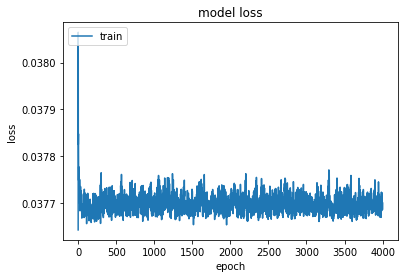

In [69]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [2]:
from matplotlib import pyplot as plt
import numpy as np

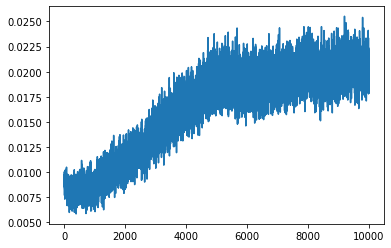

In [25]:
with open('loss_history.txt','r') as a:
    t=a.read().splitlines()
    #print(len(t))
q=[]
for i in t:
    q.append(float(i))
    #print(float(i))
plt.plot(q)
plt.show()

In [ ]:
process_bar = tqdm(range(num_iterations))
for i in process_bar:
    if(i%1000==0):
        print('eps:',epsilon)
        if(lr>0.2):
            lr=lr*lr_decay
    check_robot()
    s=get_state()
    a=choose_action(epsilon,s)
    take_action(a)
    time.sleep(delay_time)
    s1=get_state()
    reward=max(Robot.odom_data.linear.x,0)
    experience=(s,reward,a,s1)
    memory.append(experience) 
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches])
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    new_states= np.array([batch[3] for batch in batches])
    Qs =model.predict(states)

    new_Qs = model.predict(new_states)
    #print(actions)
    for i in range(len(rewards)):
        action_index=vels.index(list(actions[i]))
        #action_index=list(vels).index(actions[i])
        #print(action_index)
        Qs[i][action_index]= Qs[i][action_index]+ lr*(rewards[i]+gamma*np.max(new_Qs[i]))
    #print('sta:',len(states))
    model.fit(states,Qs,verbose=2,epochs = 20)


    if (i%1000==0):  #Save model in every 1000 iterations
        model.save('model.h5')

    model.save('model.h5')

In [12]:
from torch import nn
import torch
from torch import optim

# Layer details for the neural network
input_size = 7
hidden_sizes = [100, 50,10 ]
output_size = 6
criterion = nn.MSELoss()
# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], output_size))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=7, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=6, bias=True)
)

In [34]:
#batches=random.sample(memory,batch_size)
from torch.autograd import Variable
batches=random.sample(memory,16)

#states= np.array([batch[0] for batch in batches])
#rewards= np.array([batch[1] for batch in batches])
#actions= np.array([batch[2] for batch in batches])
#new_states= np.array([batch[3] for batch in batches])

states= torch.Tensor([batch[0] for batch in batches])

rewards= torch.Tensor([batch[1] for batch in batches])
actions= torch.Tensor([batch[2] for batch in batches])
new_states= (torch.Tensor([batch[3] for batch in batches]))

Qs =model(states.cuda())
Qs_temp=Qs
new_Qs = model(new_states.cuda())
y=4
#print('st:',states[y])
#print('newQ:',Qs[y])
##print('oldQ:',Qs_temp[y])
for i in range(len(rewards)):
    action_index=vels.index(list(actions[i]))
    #action_index=list(vels).index(actions[i])
    #print(action_index)
    next_state_values=max
    expected_Q_values=ne
    Qs[i][action_index]= (1-lr)*(Qs[i][action_index])+ lr*(rewards[i]+gamma*max(new_Qs[i].detach()))
    #expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    #Qs[i][action_index]= rewards[i]+gamma*np.max(new_Qs[i])
    if i==y:
        print('states:',states[i])
        print('next_state:',new_states[i])
        print('index:',action_index)
        print(Qs[i][action_index])
        print('rewards:',rewards[i])
        print('qs:',Qs_temp[i])
        print('pred_qs:',Qs[i])
        print('new_qs:',new_Qs[i])
        print(rewards[i]+gamma*max(new_Qs[i]))
#print('sta:',len(states))

states: tensor([ 1.3307,  2.0000,  2.0000,  0.7074,  0.4467, -0.9991,  0.4907])
next_state: tensor([ 2.0000,  2.0000,  2.0000,  1.2949,  0.5525, -0.9574,  0.4973])
index: 1
tensor(0.4935, device='cuda:0', grad_fn=<SelectBackward>)
rewards: tensor(0.4973)
qs: tensor([ 0.2440,  0.4935,  0.0485,  0.1645, -0.0331, -0.1169], device='cuda:0',
       grad_fn=<SelectBackward>)
pred_qs: tensor([ 0.2440,  0.4935,  0.0485,  0.1645, -0.0331, -0.1169], device='cuda:0',
       grad_fn=<SelectBackward>)
new_qs: tensor([ 0.2448, -0.0155,  0.0387,  0.1790, -0.0408, -0.1176], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(0.7176, grad_fn=<AddBackward0>)


In [33]:
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
#time0 = time()
epochs = 15
#optimizer.zero_grad()
#model.zero_grad()
#output = model(states.cuda())
#loss = criterion(output, Qs.cuda())

#loss.backward()

for e in range(epochs):
    running_loss = 0

    # Flatten MNIST images into a 784 long vector
    # Training pass
    output = model(states.cuda())
    loss = criterion(output, Qs.cuda())
    optimizer.zero_grad()
    #This is where the model learns by backpropagating
    loss.backward()

    #And optimizes its weights here
    optimizer.step()

    running_loss += loss.item()
    
#        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.